# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2 autogluon.tabular ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from autogluon.tabular import TabularPredictor
from autogluon.core.metrics import make_scorer
from sklearn.model_selection import KFold
from scipy.stats import pearsonr as pr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import os

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"
    
    target = "label"
    n_folds = 5
    seed = 42
    time_limit = 3600 * 11

# Loading data and predefining folds

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        
        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
def add_features(df):
    data = df.copy()
    features_df = pd.DataFrame(index=data.index)
    
    features_df['bid_ask_spread_proxy'] = data['ask_qty'] - data['bid_qty']
    features_df['total_liquidity'] = data['bid_qty'] + data['ask_qty']
    features_df['trade_imbalance'] = data['buy_qty'] - data['sell_qty']
    features_df['total_trades'] = data['buy_qty'] + data['sell_qty']
    
    features_df['volume_per_trade'] = data['volume'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    features_df['buy_volume_ratio'] = data['buy_qty'] / (data['volume'] + 1e-8)
    features_df['sell_volume_ratio'] = data['sell_qty'] / (data['volume'] + 1e-8)
    
    features_df['buying_pressure'] = data['buy_qty'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    features_df['selling_pressure'] = data['sell_qty'] / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    
    features_df['order_imbalance'] = (data['bid_qty'] - data['ask_qty']) / (data['bid_qty'] + data['ask_qty'] + 1e-8)
    features_df['order_imbalance_abs'] = np.abs(features_df['order_imbalance'])
    features_df['bid_liquidity_ratio'] = data['bid_qty'] / (data['volume'] + 1e-8)
    features_df['ask_liquidity_ratio'] = data['ask_qty'] / (data['volume'] + 1e-8)
    features_df['depth_imbalance'] = features_df['total_trades'] - data['volume']
    
    features_df['buy_sell_ratio'] = data['buy_qty'] / (data['sell_qty'] + 1e-8)
    features_df['bid_ask_ratio'] = data['bid_qty'] / (data['ask_qty'] + 1e-8)
    features_df['volume_liquidity_ratio'] = data['volume'] / (data['bid_qty'] + data['ask_qty'] + 1e-8)

    features_df['buy_volume_product'] = data['buy_qty'] * data['volume']
    features_df['sell_volume_product'] = data['sell_qty'] * data['volume']
    features_df['bid_ask_product'] = data['bid_qty'] * data['ask_qty']
    
    features_df['market_competition'] = (data['buy_qty'] * data['sell_qty']) / ((data['buy_qty'] + data['sell_qty']) + 1e-8)
    features_df['liquidity_competition'] = (data['bid_qty'] * data['ask_qty']) / ((data['bid_qty'] + data['ask_qty']) + 1e-8)
    
    total_activity = data['buy_qty'] + data['sell_qty'] + data['bid_qty'] + data['ask_qty']
    features_df['market_activity'] = total_activity
    features_df['activity_concentration'] = data['volume'] / (total_activity + 1e-8)
    
    features_df['info_arrival_rate'] = (data['buy_qty'] + data['sell_qty']) / (data['volume'] + 1e-8)
    features_df['market_making_intensity'] = (data['bid_qty'] + data['ask_qty']) / (data['buy_qty'] + data['sell_qty'] + 1e-8)
    features_df['effective_spread_proxy'] = np.abs(data['buy_qty'] - data['sell_qty']) / (data['volume'] + 1e-8)
    
    lambda_decay = 0.95
    ofi = data['buy_qty'] - data['sell_qty']
    features_df['order_flow_imbalance_ewm'] = ofi.ewm(alpha=1-lambda_decay).mean()

    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    
    return features_df

In [6]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

train = pd.concat([add_features(train), train], axis=1)
test = pd.concat([add_features(test), test], axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



In [7]:
features = [
    'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'trade_imbalance', 
    'total_trades', 'volume_per_trade', 'selling_pressure', 'ask_liquidity_ratio',
    'X2', 'X10', 'X11', 'X13', 'X14', 'X18', 'X19', 'X20', 'X26', 'X27', 'X40', 
    'X42', 'X60', 'X63', 'X64', 'X81', 'X82', 'X86', 'X87', 'X88', 'X99', 'X100',
    'X119', 'X120', 'X124', 'X125', 'X135', 'X143', 'X145', 'X157', 'X160', 'X161', 
    'X264', 'X265', 'X267', 'X269', 'X270', 'X289', 'X309', 'X314', 'X320', 'X325',
    'X331', 'X342', 'X480', 'X511', 'X534', 'X579', 'X580', 'X582', 'X602', 'X612',
    'X614', 'X764', 'X782', 'X808', 'X811', 'X863', 'X865', 'X866', 'X868', 'X877'
]

train = train[features + [CFG.target]]
test = test[features]

In [8]:
kf = KFold(n_splits=CFG.n_folds, shuffle=False)
split = kf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, "fold"] = i

# Fitting the predictor

In [9]:
def pearsonr(y_true, y_pred):
    return pr(y_true, y_pred)[0]

eval_metric = make_scorer(
    name='pearsonr',
    score_func=pearsonr,
    optimum=1,
    greater_is_better=True
)

In [10]:
predictor = TabularPredictor(
    path="/logs",
    problem_type="regression",
    eval_metric=eval_metric,
    label=CFG.target,
    groups="fold",
    verbosity=2
)

In [11]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets="best_quality",
    excluded_model_types=["KNN", "RF", "NN", "NN_TORCH"]
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       23.14 GB / 31.35 GB (73.8%)
Disk Space Avail:   1704.25 GB / 8062.39 GB (21.1%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect st

[1000]	valid_set's l2: 1.23535	valid_set's pearsonr: 0.0882163


	0.0937	 = Validation score   (pearsonr)
	158.99s	 = Training   runtime
	8.28s	 = Validation runtime
Fitting model: CatBoost_r86_BAG_L1 ... Training model for up to 16208.47s of the 16208.46s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	0.1264	 = Validation score   (pearsonr)
	185.03s	 = Training   runtime
	12.16s	 = Validation runtime
Fitting model: NeuralNetFastAI_r37_BAG_L1 ... Training model for up to 16009.32s of the 16009.31s of remaining time.
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Metric pearsonr is not supported by this model - using mean_squared_error instead
		Exception occured in `EarlyStoppingCallbackWithTimeLimit` when calling event `after_epoch`:
Detailed Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/autogluon/tabular/trainer/abstract_trainer.py", line 2169, in _train_and_save
    model = self._train_single(**mode

In [12]:
predictor.leaderboard(silent=True).style.background_gradient(subset=["score_val"], cmap="RdYlGn")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.154478,pearsonr,94.181522,1840.896133,0.053552,13.155772,2,True,47
1,LightGBM_r30_BAG_L1,0.137519,pearsonr,8.806791,216.809729,8.806791,216.809729,1,True,32
2,LightGBM_r188_BAG_L1,0.132472,pearsonr,2.552524,99.898256,2.552524,99.898256,1,True,13
3,CatBoost_r86_BAG_L1,0.126378,pearsonr,12.162605,185.031862,12.162605,185.031862,1,True,25
4,CatBoost_r13_BAG_L1,0.125250,pearsonr,12.407254,262.779288,12.407254,262.779288,1,True,12
5,CatBoost_r9_BAG_L1,0.122499,pearsonr,12.686131,205.863184,12.686131,205.863184,1,True,8
6,CatBoost_r143_BAG_L1,0.121929,pearsonr,12.849267,143.892247,12.849267,143.892247,1,True,34
7,CatBoost_r128_BAG_L1,0.121816,pearsonr,12.772771,213.806527,12.772771,213.806527,1,True,30
8,XGBoost_r98_BAG_L1,0.121499,pearsonr,3.132414,292.912063,3.132414,292.912063,1,True,23
9,LightGBM_r143_BAG_L1,0.120303,pearsonr,14.120930,291.984981,14.120930,291.984981,1,True,28


# Visualizing the ensemble weights

In [13]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

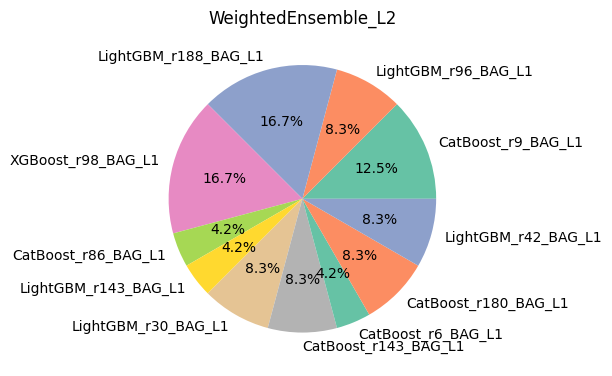

In [14]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct="%1.1f%%", colors=sns.color_palette("Set2", len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [15]:
def save_preds(preds, cv_score, name, type, is_ensemble):
    base_path = "oof_preds" if type == "oof" else "test_preds"
    base_path = "." if is_ensemble else base_path
    joblib.dump(preds, f"{base_path}/{name}_{type}_preds_{cv_score:.6f}.pkl")

def save_submission(test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub["prediction"] = test_preds
    sub.to_csv(f"sub_autogluon_{score:.6f}.csv", index=False)
    
os.makedirs("oof_preds", exist_ok=True)
os.makedirs("test_preds", exist_ok=True)

In [16]:
oof_preds = {}
test_preds = {}

overall_scores = {}

In [17]:
best_model = predictor.model_best
_test_preds = predictor.predict_multi(test)
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    model_test_preds = _test_preds[model].values
    
    cv_score = pr(train[CFG.target], model_oof_preds)[0]
    if model != best_model:
        save_preds(model_oof_preds, cv_score, model, "oof", False)
        save_preds(model_test_preds, cv_score, model, "test", False)
    else:
        save_preds(model_oof_preds, cv_score, model, "oof", True)
        save_preds(model_test_preds, cv_score, model, "test", True)
        save_submission(model_test_preds, cv_score)
        
    oof_preds[model] = model_oof_preds
    test_preds[model] = model_test_preds

    overall_scores[model] = [pr(model_oof_preds, train[CFG.target])[0]]

# Visualizing the results

In [18]:
fold_scores = {}
split = KFold(n_splits=CFG.n_folds, shuffle=False).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = pr(train.loc[val_index, CFG.target], oof_preds[model][val_index])[0]
        if model not in fold_scores:
            fold_scores[model] = []
        fold_scores[model].append(fold_score)

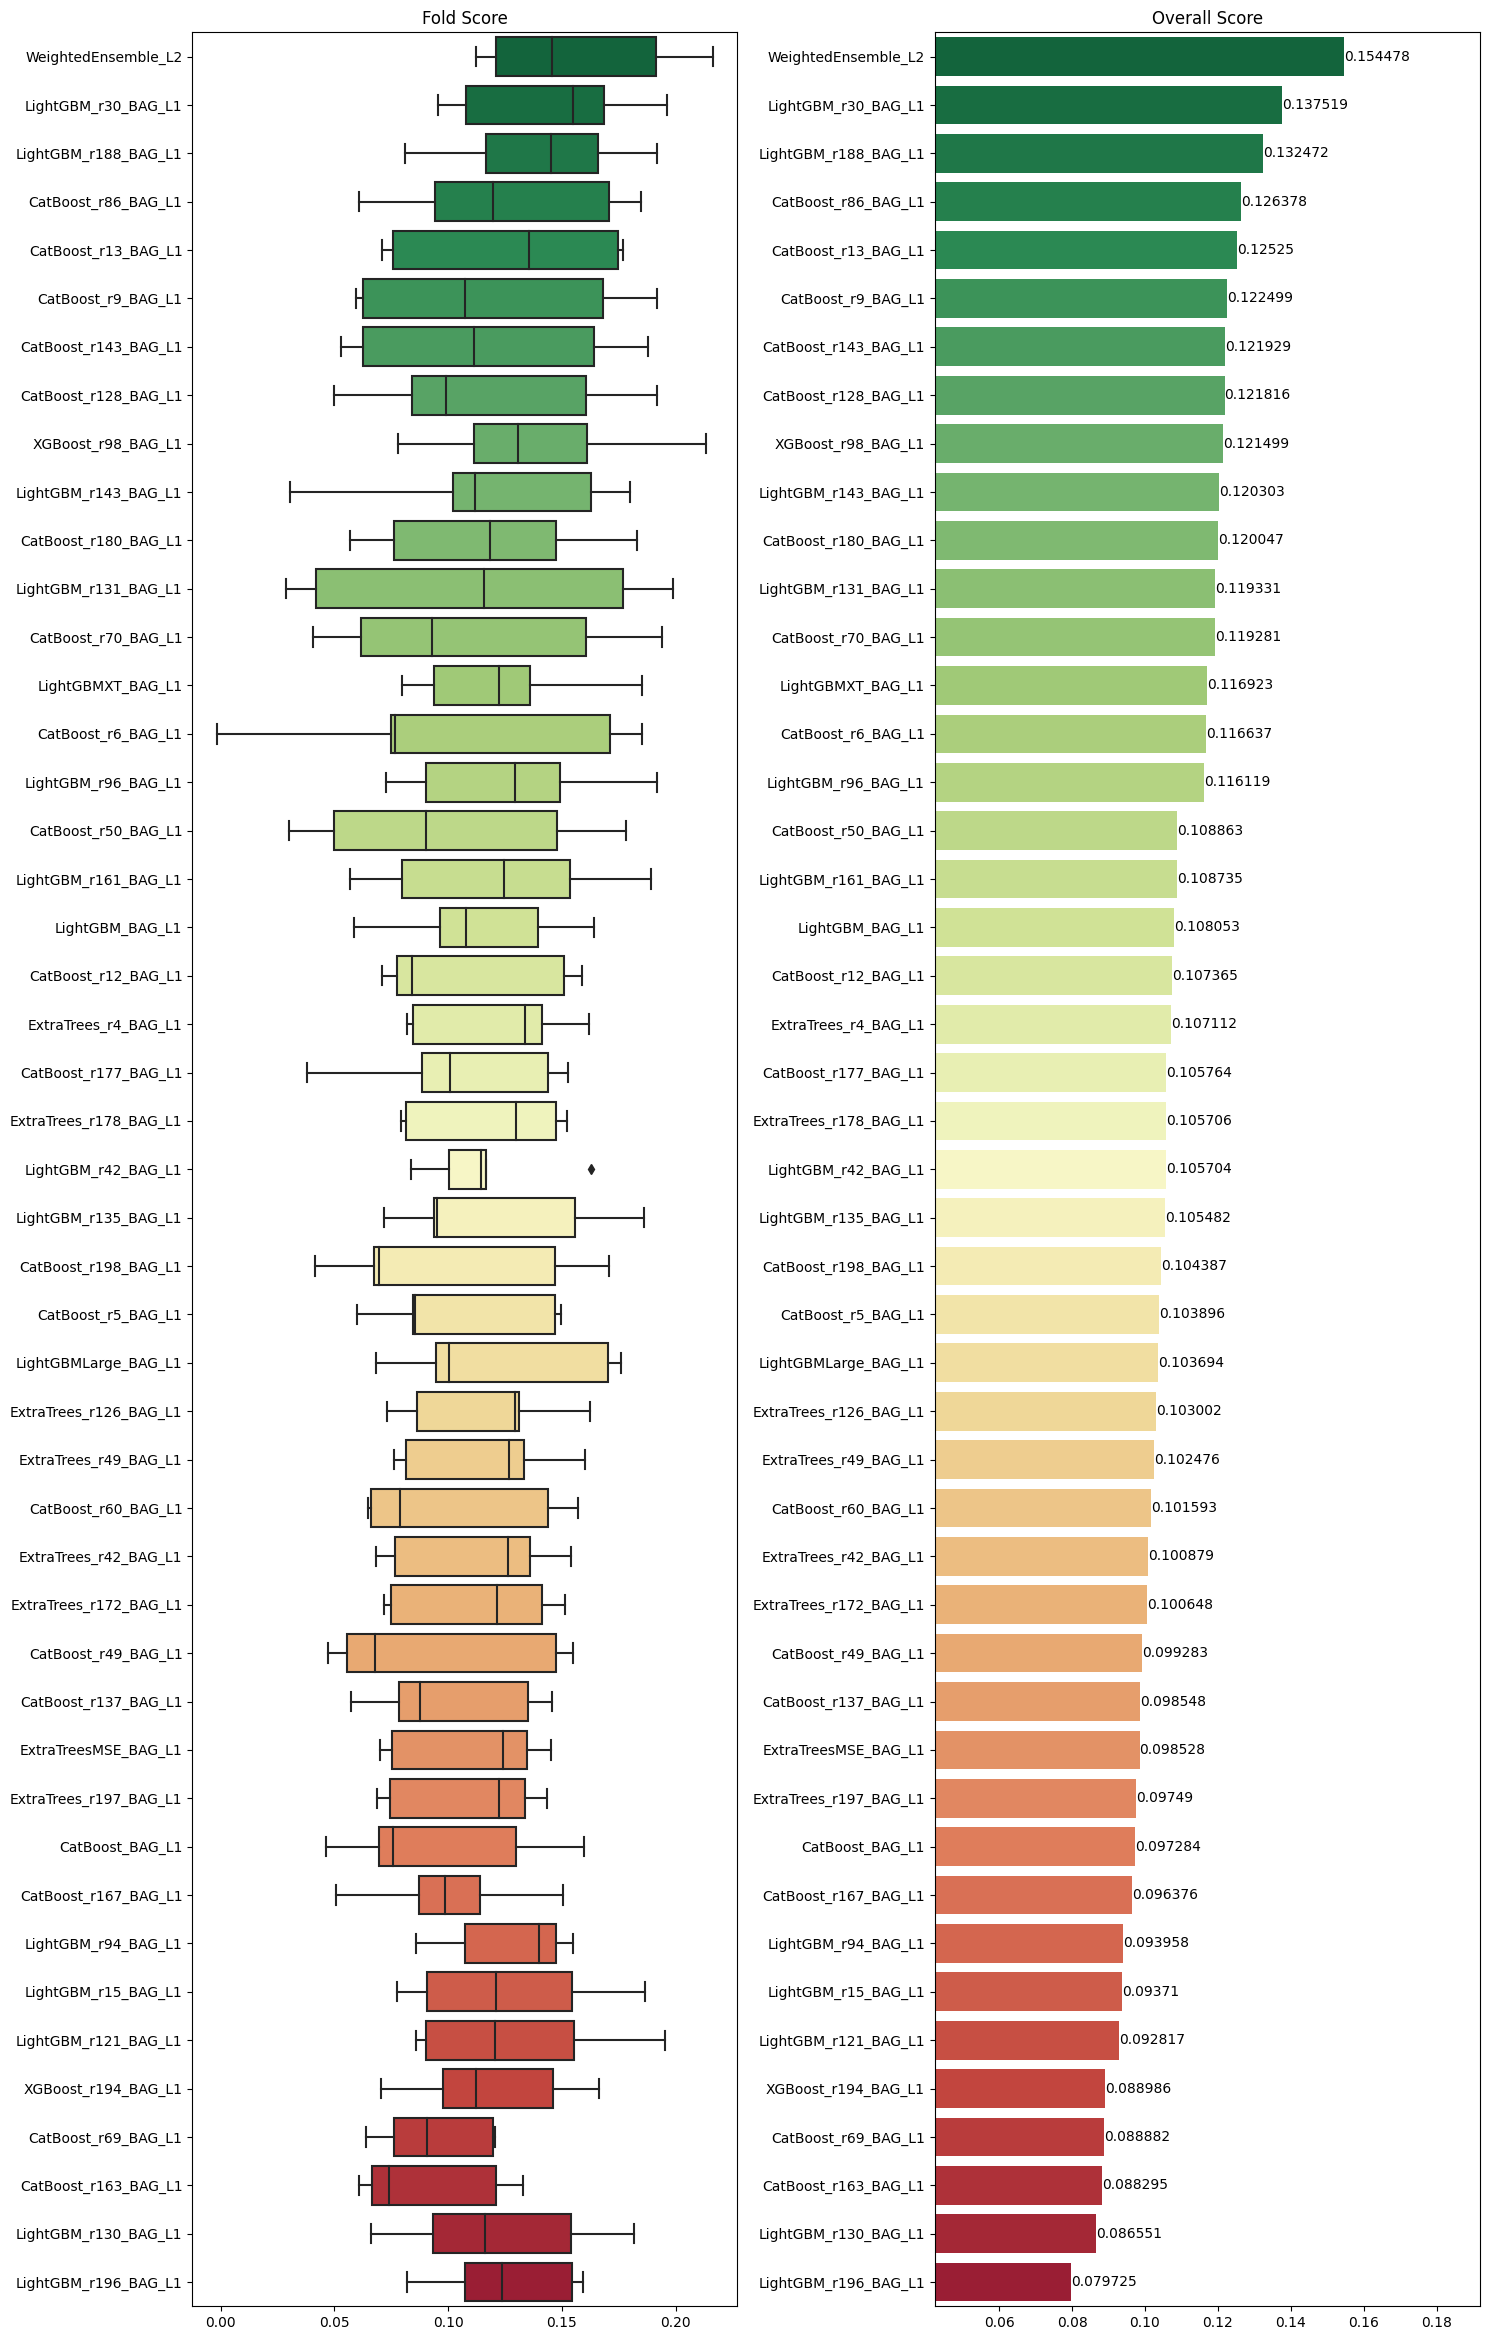

In [19]:
fold_scores = pd.DataFrame(fold_scores)
overall_scores = pd.DataFrame(overall_scores).transpose().sort_values(by=0, ascending=False)
order = overall_scores.index.tolist()

min_score = overall_scores.values.flatten().min()
max_score = overall_scores.values.flatten().max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, fold_scores.shape[1] * 0.5))

boxplot = sns.boxplot(data=fold_scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores.values.flatten(), y=overall_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title(f"Overall Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(overall_scores.values.flatten(), overall_scores.index)):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()